In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from keras import backend
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Activation
from keras.layers import Concatenate, Lambda
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator

## Hyperparams

In [ ]:
SEED = 1
np.random.seed(SEED)

TRAIN_DATA_PERCENT = 80
HEIGHT, WIDTH, CHANNELS = 48, 48, 1
CLASSES = 7
BATCH_SIZE = 64
EPOCHS = 30
AUGMENTATION = True

# if true: learning rate will change based on lr_schedule(epoch) function
# if false: learning rate will decay based on decay rate
LR_SCHEDULE = False
LR_INIT = 0.0001
LR_DECAY = 1e-6

# Learning rate scheduler to reduce Learning rate to obtain better accuracy.
def lr_schedule(epoch):
  """
  Learning Rate Schedule
  Learning rate is scheduled to be reduced after 50, 70, 80, 90 epochs.
  Called automatically every epoch as part of callbacks during training.

  # Arguments
    epoch (int): The number of epochs

  # Returns
    lr (float32): learning rate
  """
  lr = 1e-3
  if epoch > 90:
      lr *= 1e-2
  elif epoch > 60:
      lr *= 5e-2
  elif epoch > 30:
      lr *= 1e-1
  elif epoch > 5:
      lr *= 3e-1
  return lr

lr_reducer_1 = ReduceLROnPlateau(
  factor=np.sqrt(0.1),
  cooldown=0,
  patience=5,
  min_lr=0.5e-6,
  verbose=1
)

lr_reducer_2 = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=6,
  min_delta=0.0001,
  verbose=1
)

######## Do Not Change ########
model_type = "FaceNet"
checkpoint = ModelCheckpoint(
  filepath="{}_model.h5".format(model_type),
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
  verbose=1,
)
csv_logger = CSVLogger('training.log')

if LR_SCHEDULE:
  lr_scheduler = LearningRateScheduler(lr_schedule)
  OPTIMIZER = Adam(learning_rate=lr_schedule(0))
  callbacks = [checkpoint, csv_logger, lr_scheduler, lr_reducer_1]
else:
  OPTIMIZER = Adam(learning_rate=LR_INIT, decay=LR_DECAY)
  callbacks = [checkpoint, csv_logger, lr_reducer_2]

## Dataset

In [ ]:
!gdown 1t1GH1o5t9WgTE1ODB4QfpzhmuKImFY1w
!gdown 1LldCqbvgwQSt2uBrU9L33Oq5SmnQxq_Z

dataset_images = np.load('fer-2013-images.npy')
dataset_labels = np.load('fer-2013-labels.npy')

In [ ]:
# Create train and test data and labels
train_data_count = math.floor(len(dataset_images) * TRAIN_DATA_PERCENT / 100)
test_data_count = len(dataset_images) - train_data_count

# Shuffle all data in dataset. 
indexes = np.arange(len(dataset_images))
np.random.shuffle(indexes)
dataset_images = dataset_images[indexes]
dataset_labels = dataset_labels[indexes]

# Split train and test data
X_train = dataset_images[:train_data_count].astype('float32')
Y_train = dataset_labels[:train_data_count]
X_test = dataset_images[train_data_count:].astype('float32')
Y_test = dataset_labels[train_data_count:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
index = 3
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(X_train[index].squeeze(axis=2))

In [ ]:
## Train Data ##
if not AUGMENTATION:
  train_datagen = ImageDataGenerator(rescale=1./255)

else:
  train_datagen = ImageDataGenerator(
    # set rescaling factor (applied before any other transformation)
    rescale=1./255,
    # set range for random zoom
    zoom_range=0.3,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0
  )

train_set = train_datagen.flow(
  x=X_train,
  y=Y_train,
  batch_size=BATCH_SIZE,
  shuffle=True,
  seed=SEED,
)

## Test Data ##
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow(
  x=X_test,
  y=Y_test,
  batch_size=BATCH_SIZE,
  shuffle=True,
  seed=SEED,
)

## Model

In [ ]:
def conv2d(
  x,
  numfilt,
  filtsz,
  strides=1,
  pad='same',
  act=True,
  name=None,
  norm=True,
):
  x = Conv2D(
    numfilt,
    filtsz,
    strides,
    padding=pad,
    data_format='channels_last',
    use_bias=False,
    name=name+'conv2d'
  )(x)
  if norm:
    x = BatchNormalization(
      axis=3,
      scale=False,
      name=name+'conv2d'+'bn'
    )(x)
  if act:
    x = Activation(
      'relu',
      name=name+'conv2d'+'act'
    )(x)
  return x

In [ ]:
def incresA(x,scale,name=None):
  pad = 'same'
  branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
  branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
  branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
  branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
  branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
  branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
  branches = [branch0,branch1,branch2]
  mixed = Concatenate(axis=3, name=name + '_concat')(branches)
  filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
  final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                    output_shape=backend.int_shape(x)[1:],
                    arguments={'scale': scale},
                    name=name+'act_scaling')([x, filt_exp_1x1])
  return final_lay

In [ ]:
def incresB(x,scale,name=None):
  pad = 'same'
  branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
  branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
  branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
  branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
  branches = [branch0,branch1]
  mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
  filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
  final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                    output_shape=backend.int_shape(x)[1:],
                    arguments={'scale': scale},
                    name=name+'act_scaling')([x, filt_exp_1x1])
  return final_lay

In [ ]:
def incresC(x,scale,name=None):
  pad = 'same'
  branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
  branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
  branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
  branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
  branches = [branch0,branch1]
  mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
  filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
  final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                    output_shape=backend.int_shape(x)[1:],
                    arguments={'scale': scale},
                    name=name+'act_saling')([x, filt_exp_1x1])
  return final_lay

In [ ]:
def FaceNet(input_shape, num_classes):

  inputs = Input(input_shape)

  x = conv2d(inputs,32,3,2,'valid',True,name='conv1')
  x = conv2d(x,32,3,1,'valid',True,name='conv2')
  x = conv2d(x,64,3,1,'valid',True,name='conv3')

  x_11 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
  x_12 = conv2d(x,64,3,1,'valid',True,name='stem_br_12')

  x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

  x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
  x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
  x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
  x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

  x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
  x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

  x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

  x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
  x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
  x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

  #Inception-ResNet-A modules
  x = incresA(x,0.15,name='incresA_1')
  x = incresA(x,0.15,name='incresA_2')
  x = incresA(x,0.15,name='incresA_3')
  x = incresA(x,0.15,name='incresA_4')

  #35 × 35 to 17 × 17 reduction module.
  x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

  x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

  x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
  x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
  x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

  x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

  #Inception-ResNet-B modules
  x = incresB(x,0.1,name='incresB_1')
  x = incresB(x,0.1,name='incresB_2')
  x = incresB(x,0.1,name='incresB_3')
  x = incresB(x,0.1,name='incresB_4')
  x = incresB(x,0.1,name='incresB_5')
  x = incresB(x,0.1,name='incresB_6')
  x = incresB(x,0.1,name='incresB_7')

  #17 × 17 to 8 × 8 reduction module.
  x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

  x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
  x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

  x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
  x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

  x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
  x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
  x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

  x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

  #Inception-ResNet-C modules
  x = incresC(x,0.2,name='incresC_1')
  x = incresC(x,0.2,name='incresC_2')
  x = incresC(x,0.2,name='incresC_3')

  #TOP
  x = GlobalAveragePooling2D(data_format='channels_last')(x)
  x = Dropout(0.6)(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs, name=model_type)
  return model

## Model Summary

In [ ]:
model = FaceNet(
  input_shape=(HEIGHT, WIDTH, CHANNELS),
  num_classes=CLASSES
)

model.compile(
  loss='categorical_crossentropy',
  optimizer=OPTIMIZER,
  metrics=['accuracy']
)

In [15]:
train_loss, train_acc = model.evaluate(train_set)
test_loss, test_acc = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

113/113 [==============================] - 5s 47ms/step - loss: 1.0362 - accuracy: 0.6057
final train accuracy = 64.01 , validation accuracy = 60.57


In [16]:
model.save_weights("{}_best.h5".format(model_type))

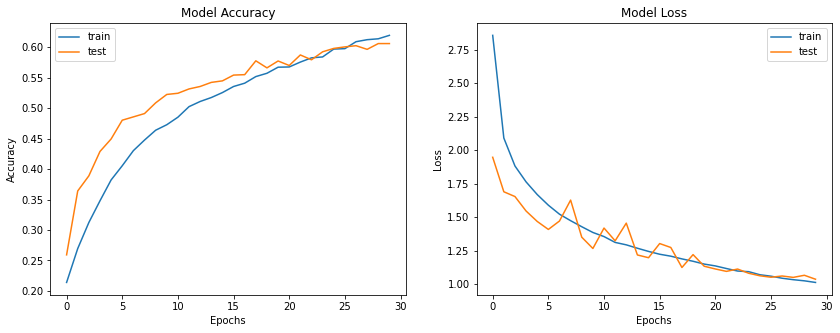

In [17]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.show()